Twoim zadaniem jest wytrenowanie klasyfikatora binarnego na podzbiorze zbioru MNIST, w którym wyróżniamy klasy (cyfry 0 i 1 mają zostać wyłączone ze zbioru):
 - Liczby pierwsze (2,3,5,7)
 - Liczby złożone (4,6,8,9)

Napisz wydajną implementację modelu **regresji logistycznej** trenowanego algorytmem ***SGD z momentum***. Cały proces trenowania musisz napisać samodzielnie, w języku Python, korzystając z biblioteki numpy. Na potrzeby zadania niedozwolone jest korzystanie z gotowych implementacji optimizerów i modeli oraz bibliotek do automatycznego różniczkowania funkcji (np. Tensorflow, pytorch, autograd). 

Dobierz hiperparametry tak, aby uzyskać jak najlepszy wynik na zbiorze walidacyjnym. 
Wyciągnij i zapisz wnioski z przeprowadzonych eksperymentów.

Zbiór MNIST dostępny jest pod linkami: 

(zbiór treningowy):
 - http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
 - http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz

(zbiór walidacyjny):
 - http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
 - http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz



# LOADING MNIST DATA SET

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from mlxtend.data import loadlocal_mnist

To load data set I used mlxtend.data library. 
The whole training process is written with python and NumPy library only.

In [3]:
if not os.path.exists("train-images-idx3-ubyte"):
    !curl -O http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
    !curl -O http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
    !curl -O http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
    !curl -O http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
    !gunzip t*-ubyte.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 10 9680k   10 1009k    0     0  1038k      0  0:00:09 --:--:--  0:00:09 1038k
100 9680k  100 9680k    0     0  4194k      0  0:00:02  0:00:02 --:--:-- 4195k
100 9680k  100 9680k    0     0  4194k      0  0:00:02  0:00:02 --:--:-- 4194k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 28881  100 28881    0     0  67321      0 --:--:-- --:--:-- --:--:-- 67321
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:

# Data Preparation

LOADING DATA into training set and validation set

In [2]:
X_train, y_train = loadlocal_mnist(
        images_path='/Users/Kuban/CLOUD/PYTHON/JupyterNootbookProjects/ML/Allegro_LogReg/train-images.idx3-ubyte', 
        labels_path='/Users/Kuban/CLOUD/PYTHON/JupyterNootbookProjects/ML/Allegro_LogReg/train-labels.idx1-ubyte')

In [3]:
X_test, y_test = loadlocal_mnist(
        images_path='/Users/Kuban/CLOUD/PYTHON/JupyterNootbookProjects/ML/Allegro_LogReg/t10k-images.idx3-ubyte', 
        labels_path='/Users/Kuban/CLOUD/PYTHON/JupyterNootbookProjects/ML/Allegro_LogReg/t10k-labels.idx1-ubyte')

Excluding 0 and 1 from our training and validation sets

In [47]:
def exclude(digit, x, y):
    idx = (y != digit).nonzero()
    return x[idx], y[idx]

In [48]:
X_train_no0, y_train_no0 = exclude(0, X_train, y_train)
X_test_no0, y_test_no0 = exclude(0, X_test, y_test)
train_images, train_labels = exclude(1, X_train_no0, y_train_no0)
test_images, test_labels = exclude(1, X_test_no0, y_test_no0)

Labelling data from digit to binary representation 1 - prime, 0 - odd

In [49]:
def isPrime(n):
    if (n==2):
        return True;
    else:
        for x in range(2,n):
            if(n % x == 0):
                return False
    return True             

In [51]:
def TrainLabelling():
    for i in range(len(train_labels)):
        if(isPrime(train_labels[i])):
            train_labels[i] = 1
        else:
            train_labels[i] = 0

In [52]:
def TestLabelling():
    for i in range(len(test_labels)):
        if(isPrime(test_labels[i])):
            test_labels[i] = 1
        else:
            test_labels[i] = 0

In [53]:
TrainLabelling()
TestLabelling()

In [54]:
print('Shape of train_images: {}, Dim: {}, Type: {} '.format(train_images.shape, train_images.ndim, type(train_images)))
print('Shape of test_images: {}, Dim: {}, Type: {}'.format(test_images.shape, test_images.ndim, type(test_images)))
print('Shape of train_labels: {}, Dim: {}, Type: {}'.format(train_labels.shape, train_labels.ndim, type(train_labels)))
print('Shape of test_labels: {}, Dim: {}, Type: {}'.format(test_labels.shape, test_labels.ndim, type(test_labels)))

Shape of train_images: (47335, 784), Dim: 2, Type: <class 'numpy.ndarray'> 
Shape of test_images: (7885, 784), Dim: 2, Type: <class 'numpy.ndarray'>
Shape of train_labels: (47335,), Dim: 1, Type: <class 'numpy.ndarray'>
Shape of test_labels: (7885,), Dim: 1, Type: <class 'numpy.ndarray'>


# RANDOM BATCH

In [563]:
def get_random_batch(x,y,batch_size):
    
    num_features = 784
    num_total = x.shape[0]
    X = np.zeros((batch_size, num_features))
    Y = np.zeros((batch_size, 1))
    
    indices = np.random.randint(0, num_total, batch_size)
    
    for i, index in enumerate(indices):
        X[i] = np.reshape(x[index], (num_features, ))
        Y[i] = np.array(y[index])
        
    return X,Y     

In [564]:
def show_example(example, label, dim = (28,28)):
    
    example = np.squeeze(example)
    label = np.squeeze(label)
    if example.shape != dim:
        example = example.reshape(dim)
    plt.imshow(example, cmap='binary')
    plt.xlabel('Label: ' + str(int(label)))
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [565]:
def show_ten_examples(examples, labels, preds):
    
    plt.figure(figsize=(8,4))
    for i in range(0,10):
        plt.subplot(2,5,i+1)
        plt.imshow(np.reshape(examples[i], (28,28)), cmap = 'binary')
        plt.xticks([])
        plt.yticks([])
        y = int(np.squeeze(labels[i]))
        p = int(np.squeeze(preds[i]))
        plt.xlabel(str(p), color = 'green' if y==p else 'red')
    plt.show()

X_batch shape (1, 784)


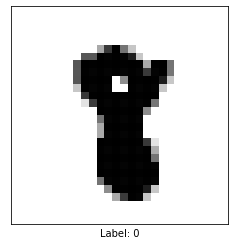

In [566]:
X_batch, Y_batch = get_random_batch(train_images, train_labels, 1)
print('X_batch shape', X_batch.shape)
show_example(X_batch[0], Y_batch[0])

ABOVE A EXAMPLE OF RANDOM NUMBER FROM TRAINSET 

X_batch shape (1, 784)


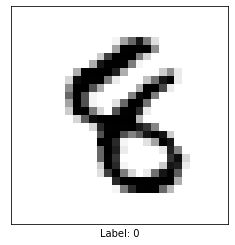

In [567]:
X_batch, Y_batch = get_random_batch(test_images, test_labels, 1)
print('X_batch shape', X_batch.shape)
show_example(X_batch[0], Y_batch[0])

ABOVE A EXAMPLE OF RANDOM NUMBER FROM TESTSET

# OUR LOGISTIC REGRESSION MODEL

In [578]:
class Model:
    
    def __init__(self, num_features,  lr = 0.3, iterations = 2000, batch_size = 100, momentum = 0.9):
        self.W = np.reshape(np.random.randn((num_features)), (num_features, 1))
        self.b = np.zeros((1,1))
        self.num_features = num_features
        self.lr = lr
        self.iterations = iterations
        self.batch_size = batch_size
        self.momentum = momentum
        self.losses = []
        self.accuracies = []
        np.random.seed(4)
        
        
    @staticmethod
    def get_random_batch(X, Y, batch_size):
    
        num_features = 784
        num_total = X.shape[0]
        x = np.zeros((batch_size, num_features))
        y = np.zeros((batch_size, 1))
    
        indices = np.random.randint(0, num_total, batch_size)
    
        for i, index in enumerate(indices):
            x[i] = np.reshape(X[index], (num_features, ))
            y[i] = np.array(Y[index])
        
        return x,y
    
    def linear(self, X: np.ndarray):
        return np.dot(X, self.W) + self.b
    
    def sigmoid(self, X: np.ndarray):
        return 1/(1 + np.exp(-X))
        
    def forward_pass(self, X: np.ndarray, y: np.ndarray = None):
        batch_size = X.shape[0]
        probs = self.sigmoid(self.linear(X))
        return probs
    
    def backward_pass(self, probs, X: np.ndarray, y: np.ndarray):
        batch_size = X.shape[0]
        error = probs-y
        dW = np.dot(np.transpose(X), error) / batch_size
        db = np.sum(error) / batch_size
        W_velocity = np.zeros(dW.shape)
        b_velocity = np.zeros(db.shape)
        W_velocity = self.momentum * W_velocity + self.lr * dW
        b_velocity = self.momentum * b_velocity + self.lr * db
        self.W -= W_velocity
        self.b -= b_velocity
        
    def predict(self, X: np.ndarray) -> np.ndarray:
        preds = self.sigmoid(self.linear(X))
        preds = preds >= 0.5
        return np.squeeze(preds)
    
    def evaluate(self, X: np.ndarray, y: np.ndarray) -> float:
        preds = self.predict(X)
        accuracy = np.sum(preds == np.squeeze(y)) / X.shape[0]
        return accuracy
    
    def loss(self, X: np.ndarray, y: np.ndarray):
        batch_size = X.shape[0]
        probs = self.sigmoid(self.linear(X))
        loss = float(1e5)
        if Y is not None:
            loss = -1 * np.sum(np.dot(np.transpose(Y), np.log(probs + 1e-8)) + np.matmul(np.transpose(1-Y), np.log(1-probs + 1e-8)))
            loss /= batch_size
        return loss
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        for i in range(self.iterations):
            if (i % 100 == 0):
                self.lr*=0.1
            X_train, Y_train = self.get_random_batch(X, y, self.batch_size)
            probs = self.forward_pass(X_train, Y_train) 
            self.backward_pass(probs, X_train, Y_train)
            
            

# TESTING OUR MODEL

In [579]:
model = Model(784)

X, Y = get_random_batch(test_images, test_labels, 7000)
print('Before training performace, Accuracy: ', model.evaluate(X, Y))
print("Loss: ", model.loss(X,Y))


model.fit(train_images, train_labels)

print('After training performace, Accuracy: ', model.evaluate(X, Y))
print('Loss: ', model.loss(X,Y))

Before training performace, Accuracy:  0.415
Loss:  10.737582995822413
After training performace, Accuracy:  0.9155714285714286
Loss:  1.5460731674700703


As we can see, the accuracy is 0.915, while our hyperparameters are:
lr = 0.3, iteratons = 2000, batch_size = 100 and momentum = 0.9

In the case of iterations changes, we receive 0.91 accuracy for 1000 iterations, 0.912 for 3000 iterations. When we increase iterations to 5000 or more our result does not improve. We can notice that the best accuracy is when we have around 2000 iterations.

In case of batch_size changes we receive: 0.9 accuracy when batch_size is equal 50, 0.912 for batch_size = 200.
When we rapidly increase our batch_size for example around 1000 our accuracy is 0.9. The best result is for batch_size equal to 100.

Thinking about learning_reate and momentum, we should remember, that if out momentum parameter is too high, we will not be able to receive better learning time (faster searching minimum with SGD). Learning_rate should stay 0.3 because it gives the best result.

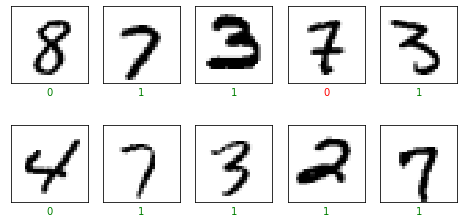

In [580]:
preds = model.predict(X)
show_ten_examples(X, Y, preds)

ABOVE SOME RANDOM EXAMPLES OF PREDICTIONS

Under random image examples, are labels, if our model predicted correctly label is green, if incorrectly red.